In [1]:
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, \
                confusion_matrix, classification_report

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('CleanedData.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 12/27/2013 to 10/24/2018
Data columns (total 24 columns):
com_count                   1763 non-null int64
sub_count                   1763 non-null int64
com_body_pos_count          1763 non-null int64
com_body_very_pos_count     1763 non-null int64
com_body_neg_count          1763 non-null int64
com_body_very_neg_count     1763 non-null int64
sub_body_pos_count          1763 non-null int64
sub_body_very_pos_count     1763 non-null int64
sub_body_neg_count          1763 non-null int64
sub_body_very_neg_count     1763 non-null int64
sub_title_pos_count         1763 non-null int64
sub_title_very_pos_count    1763 non-null int64
sub_title_neg_count         1763 non-null int64
sub_title_very_neg_count    1763 non-null int64
avg_clust_coef              1763 non-null float64
avg_degree                  1763 non-null float64
num_edges                   1763 non-null float64
num_nodes                   1763 non-null float64
bitcoin_ope

In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,
12/27/2013,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,0.006916,1.41,2856.0,2019.0,763.28,777.51,713.60,735.07,46862700,9295569920
12/28/2013,5335,354,1364,659,565,226,85,63,23,14,54,14,21,5,0.004497,1.43,2689.0,1883.0,737.98,747.06,705.35,727.83,32505800,8990850048
12/29/2013,5413,341,1347,649,615,245,92,67,17,4,43,10,25,3,0.007134,1.30,2436.0,1877.0,728.05,748.61,714.44,745.05,19011300,8872599552
12/30/2013,5757,447,1547,783,659,277,96,65,31,19,48,14,27,5,0.004985,1.42,2762.0,1944.0,741.35,766.60,740.24,756.13,20707700,9036999680
12/31/2013,4772,352,1162,591,577,224,90,77,19,7,50,11,20,5,0.003238,1.25,2234.0,1789.0,760.32,760.58,738.17,754.01,20897300,9268240384


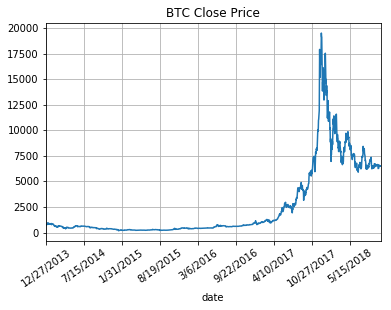

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35)

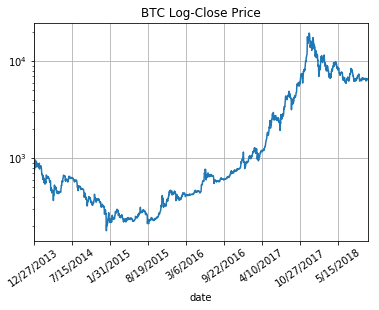

In [ ]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35)

In [ ]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1763.0
number of months:  58.8
number of years:    4.8


## Preparing Data

In [ ]:
# function to prep data and return DF for modeling

def prepare_data(n_lags=1):
    # read in  dataset and initialize output df
    df = pd.read_csv('CleanedData.csv',index_col='date')
    
    col_list = df.columns
    
    
    # create lag columns for each other variable
    for lag in range(n_lags):
        for col in col_list:
            df['{}_(-{})'.format(col,lag+1)] = df[col].shift(lag+1)
    
    # create column to hold tomorrow's close for each day
    df['tomorrow_close'] = df['bitcoin_close'].shift(-1)
    # change in price between consecutive closing days
    df['day_change'] = df['tomorrow_close'] - df['bitcoin_close']
    # indicator variable to be used for predicting higher/lower days
    df['y'] = np.where(df['day_change'] >= 0, 1, 0)
    
    # drop intermediate columns
    df.drop(['tomorrow_close', 'day_change'], axis=1, inplace=True)
    
    # return and drop na
    return df.dropna()

In [ ]:
# create DF for analysis
df = prepare_data(n_lags=5)

In [ ]:
# inspect df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, 1/1/2014 to 10/24/2018
Columns: 145 entries, com_count to y
dtypes: float64(128), int32(1), int64(16)
memory usage: 2.0+ MB


In [ ]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap,com_count_(-1),sub_count_(-1),com_body_pos_count_(-1),com_body_very_pos_count_(-1),com_body_neg_count_(-1),com_body_very_neg_count_(-1),sub_body_pos_count_(-1),sub_body_very_pos_count_(-1),sub_body_neg_count_(-1),sub_body_very_neg_count_(-1),sub_title_pos_count_(-1),sub_title_very_pos_count_(-1),sub_title_neg_count_(-1),sub_title_very_neg_count_(-1),avg_clust_coef_(-1),avg_degree_(-1),num_edges_(-1),num_nodes_(-1),bitcoin_open_(-1),bitcoin_high_(-1),bitcoin_low_(-1),bitcoin_close_(-1),bitcoin_volume_(-1),bitcoin_market_cap_(-1),com_count_(-2),sub_count_(-2),com_body_pos_count_(-2),com_body_very_pos_count_(-2),com_body_neg_count_(-2),com_body_very_neg_count_(-2),sub_body_pos_count_(-2),sub_body_very_pos_count_(-2),sub_body_neg_count_(-2),sub_body_very_neg_count_(-2),sub_title_pos_count_(-2),sub_title_very_pos_count_(-2),sub_title_neg_count_(-2),sub_title_very_neg_count_(-2),avg_clust_coef_(-2),avg_degree_(-2),num_edges_(-2),num_nodes_(-2),bitcoin_open_(-2),bitcoin_high_(-2),bitcoin_low_(-2),bitcoin_close_(-2),bitcoin_volume_(-2),bitcoin_market_cap_(-2),com_count_(-3),sub_count_(-3),com_body_pos_count_(-3),com_body_very_pos_count_(-3),com_body_neg_count_(-3),com_body_very_neg_count_(-3),sub_body_pos_count_(-3),sub_body_very_pos_count_(-3),sub_body_neg_count_(-3),sub_body_very_neg_count_(-3),sub_title_pos_count_(-3),sub_title_very_pos_count_(-3),sub_title_neg_count_(-3),sub_title_very_neg_count_(-3),avg_clust_coef_(-3),avg_degree_(-3),num_edges_(-3),num_nodes_(-3),bitcoin_open_(-3),bitcoin_high_(-3),bitcoin_low_(-3),bitcoin_close_(-3),bitcoin_volume_(-3),bitcoin_market_cap_(-3),com_count_(-4),sub_count_(-4),com_body_pos_count_(-4),com_body_very_pos_count_(-4),com_body_neg_count_(-4),com_body_very_neg_count_(-4),sub_body_pos_count_(-4),sub_body_very_pos_count_(-4),sub_body_neg_count_(-4),sub_body_very_neg_count_(-4),sub_title_pos_count_(-4),sub_title_very_pos_count_(-4),sub_title_neg_count_(-4),sub_title_very_neg_count_(-4),avg_clust_coef_(-4),avg_degree_(-4),num_edges_(-4),num_nodes_(-4),bitcoin_open_(-4),bitcoin_high_(-4),bitcoin_low_(-4),bitcoin_close_(-4),bitcoin_volume_(-4),bitcoin_market_cap_(-4),com_count_(-5),sub_count_(-5),com_body_pos_count_(-5),com_body_very_pos_count_(-5),com_body_neg_count_(-5),com_body_very_neg_count_(-5),sub_body_pos_count_(-5),sub_body_very_pos_count_(-5),sub_body_neg_count_(-5),sub_body_very_neg_count_(-5),sub_title_pos_count_(-5),sub_title_very_pos_count_(-5),sub_title_neg_count_(-5),sub_title_very_neg_count_(-5),avg_clust_coef_(-5),avg_degree_(-5),num_edges_(-5),num_nodes_(-5),bitcoin_open_(-5),bitcoin_high_(-5),bitcoin_low_(-5),bitcoin_close_(-5),bitcoin_volume_(-5),bitcoin_market_cap_(-5),y
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1/1/2014,4173,288,997,496,468,172,63,47,17,9,42,8,13,3,0.006140,1.20,1900.0,1581.0,754.97,775.35,754.97,771.40,22489400,9203030016,4772.0,352.0,1162.0,591.0,577.0,224.0,90.0,77.0,19.0,7.0,50.0,11.0,20.0,5.0,0.003238,1.25,2234.0,1789.0,760.32,760.58,738.17,754.01,20897300.0,9.268240e+09,5757.0,447.0,1547.0,783.0,659.0,277.0,96.0,65.0,31.0,19.0,48.0,14.0,27.0,5.0,0.004985,1.42,2762.0,1944.0,741.35,766.60,740.24,756.13,20707700.0,9.037000e+09,5413.0,341.0,1347.0,649.0,615.0,245.0,92.0,67.0,17.0,4.0,43.0,10.0,25.0,3.0,0.007134,1.30,2436.0,1877.0,728.05,748.61,714.44,745.05,19011300.0,8.872600e+09,5335.0,354.0,1364.0,659.0,565.0,226.0,85.0,63.0,23.0,14.0,54.0,14.0,21.0,5.0,0.004497,1.43,2689.0,1883.0,737.98,747.06,705.35,727.83,32505800.0,8.990850e+09,6065.0

In [ ]:
# balance of dependent variable values
df.y.value_counts()

1    947
0    811
Name: y, dtype: int64

## Splitting For Training and Testing

In [ ]:
# function to create train/test X and y
def create_training_test_splits(df_in, train_split=0.7, rescale=True):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1))
        cols = X.columns
        X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
        X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
        
    # extract values of X and y
    X_train, X_test = X_train.values, X_test.values
    y_train, y_test = y_train.values, y_test.values
    
    # reshape input to be LSTM format [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = create_training_test_splits(df, train_split=0.8, rescale=True)

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\envs\CryptoProject\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\envs\CryptoProject\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda3\envs\CryptoProject\lib\site-packages\ipykerne

## Build, Train, Test LSTM Model

In [ ]:
# function to create and train model

def run_model(lstm_neurs=100, dense_neurs=10, dropout_lstm=0.2, dropout_dense1=0.2, dropout_dense2=0.2,\
              dropout_recurr=0.2, l2_lstm=0.01, l2_dense=0.01, batch_size=14, \
              kernel_initializer='glorot_uniform', epochs=10):
    # create LSTM model
    model = Sequential()
    model.add(LSTM(lstm_neurs, kernel_initializer=kernel_initializer, 
                   input_shape=(X_train.shape[1], X_train.shape[2]), 
                   dropout=dropout_lstm, recurrent_dropout=dropout_recurr,
                    kernel_regularizer=regularizers.l2(l2_lstm)))
    model.add(Dropout(dropout_dense1))
    model.add(Dense(dense_neurs, activation='relu', kernel_regularizer=regularizers.l2(l2_dense)))
    model.add(Dropout(dropout_dense2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model and output summary 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=2)
    y_pred = np.round(model.predict(X_test))
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, accuracy

In [ ]:
model,acc  = run_model(lstm_neurs=100, dense_neurs=10, dropout_lstm=0.2, dropout_dense1=0.2, dropout_dense2=0.2,\
              dropout_recurr=0.2, l2_lstm=0.01, l2_dense=0.01, batch_size=30, \
              kernel_initializer='glorot_uniform', epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               98000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 99,021
Trainable params: 99,021
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1406/1406 [==============================] - 3s 2ms/step - loss: 1.9799 - acc: 0.5164
Epoch 2/10
1406/1406 [==============

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Optimizing Training and LSTM Model Parameters

In [ ]:
def run_simulations(uniques=True, timer=True):
    # run all simulations to find best model
    if timer:
        start = time.time()
    
    # number of lags
    n_lags = [0, 7, 14]
    # train/test splits
    train_splits = [0.75, 0.9]
    
    # neurons
    # number of neurons in LSTM
    lstm_neurons = [10, 50, 100]
    # number of neurons in Dense
    dense_neurons = [5, 10]
    
    # dropouts
    # dropout of LSTM layer
    dropout_lstm = [0.1, 0.25]
    # dropout of layer before Dense layer
    dropout_dense1 = [0.25]
    # dropout of layer after Dense layer
    dropout_dense2 = [0.25]
    # dropout in recurrent layer of LSTM
    dropout_recurr = [0.1]
    
    # training and initializers
    # batch size of iterations
    batch_size = [7, 30]
    # kernel initializers for LSTM layer
    kernel_initializer=['glorot_uniform', 'glorot_normal']
    
    # regularization
    # regularization penalties for LSTM layer
    l2s_lstms = [0.1]
    # regularization penalties for Dense layer
    l2s_denses = [0.25]
    
    # misc
    # epochs for iterations
    epochs = [5]
    # dashes for formatting
    dashes = 65
    
    # RUN
    # number of reports to keep track
    report = 0
    accs = set()
    
    # data preparation parameters
    for lag in n_lags:
        # read in data and create lags
        df = prepare_data(n_lags=lag)
        for split in train_splits:
            # create training and test data
            X_train, X_test, y_train, y_test = create_training_test_splits(
                                    df, train_split=split, rescale=True)

            # run all simulations of for modeling parameters
            for lstm_n in lstm_neurons:
                for dense_n in dense_neurons:
                    for d_lstm in dropout_lstm:
                        for d_dense1 in dropout_dense1:
                            for d_dense2 in dropout_dense2:
                                for d_recurr in dropout_recurr:
                                    for l2_lstm in l2s_lstms:
                                        for l2_dense in l2s_denses:
                                            for batch in batch_size:
                                                for k_init in kernel_initializer:
                                                    for e in epochs:
                                                        # print output
                                                        report += 1
                                                        print('='*dashes)
                                                        print('REPORT # {}'.format(report))
                                                        print('='*dashes)
                                                        print('Training Parameters')
                                                        print('Number of lags    = {}'.format(lag))
                                                        print('Training Data %   = {:0.1f}%'.format(split*100))
                                                        print('='*dashes)
                                                        print('Model Parameters')
                                                        print('LSTM Neurons      = {}'.format(lstm_n))
                                                        print('Dense Neurons     = {}'.format(dense_n))
                                                        print('Dropout LSTM      = {}'.format(d_lstm))
                                                        print('Dropout Dense1    = {}'.format(d_dense1))
                                                        print('Dropout Dense2    = {}'.format(d_dense2))
                                                        print('Dropout Recurrent = {}'.format(d_recurr))
                                                        print('L2 - LSTM Layer   = {}'.format(l2_lstm))
                                                        print('L2 - Dense Layer  = {}'.format(l2_dense))
                                                        print('Batch Size        = {}'.format(batch))
                                                        print('Kernel Init.      = {}'.format(k_init))
                                                        print('Epochs            = {}'.format(e))
                                                        print('='*dashes)
                                                        # execute model
                                                        model, acc = run_model(lstm_neurs=lstm_n, dense_neurs=dense_n, \
                                                                  dropout_lstm=d_lstm, dropout_dense1=d_dense1, \
                                                                  dropout_dense2=d_dense2, dropout_recurr=d_recurr, \
                                                                  l2_lstm=l2_lstm, l2_dense=l2_dense, batch_size=batch, \
                                                                  kernel_initializer=k_init, epochs=e)
                                                        # update minimum accuracy and skip over
                                                        # any models with same as previous accuracy scores
                                                        if acc in accs and uniques: continue
                                                        model.save('models/model-{}_acc-{}.h5'.format( \
                                                                report, round(acc)))
                                                        accs.add(acc)
                                                        print('='*dashes)
    if timer:
        end = time.time()
        print('Process took {:.2f} seconds'.format(end-start))

In [ ]:
# run all simulations
run_simulations(uniques=True)

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\envs\CryptoProject\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\envs\CryptoProject\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda3\envs\CryptoProject\lib\site-packages\ipykerne

REPORT # 1
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 10
Dense Neurons     = 5
Dropout LSTM      = 0.1
Dropout Dense1    = 0.25
Dropout Dense2    = 0.25
Dropout Recurrent = 0.1
L2 - LSTM Layer   = 0.1
L2 - Dense Layer  = 0.25
Batch Size        = 7
Kernel Init.      = glorot_uniform
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                6200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_______________________________________

C:\Anaconda3\envs\CryptoProject\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


REPORT # 2
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 10
Dense Neurons     = 5
Dropout LSTM      = 0.1
Dropout Dense1    = 0.25
Dropout Dense2    = 0.25
Dropout Recurrent = 0.1
L2 - LSTM Layer   = 0.1
L2 - Dense Layer  = 0.25
Batch Size        = 7
Kernel Init.      = glorot_normal
Epochs            = 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                6200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                6200      
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_12 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 6,261
Trainable params: 6,261
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1406/1406 [==============================] - 3s 2ms/step - loss: 3.3357 - acc: 0.5249
Epoch 2/5
1406/1406 [==================

Epoch 1/5
1406/1406 [==============================] - 2s 2ms/step - loss: 6.3694 - acc: 0.5228
Epoch 2/5
1406/1406 [==============================] - 0s 237us/step - loss: 3.6910 - acc: 0.5391
Epoch 3/5
1406/1406 [==============================] - 0s 210us/step - loss: 2.3741 - acc: 0.5398
Epoch 4/5
1406/1406 [==============================] - 0s 218us/step - loss: 1.7004 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 0s 242us/step - loss: 1.3380 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 9
Training Parameters
Number of la

Epoch 4/5
1406/1406 [==============================] - 0s 216us/step - loss: 2.0635 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 0s 220us/step - loss: 1.6331 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 12
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 10
Dense Neurons     = 10
Dropout LSTM      = 0.1
Dropout Dense1    = 0.25
Dropout Dense2    = 0.25
Dropout Recurrent = 0.1
L2 - LSTM Layer   = 0.1
L2 - Dense Layer  = 0.25
Batch Size        = 30
Kernel Init.      = gl

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10)                6200      
_________________________________________________________________
dropout_31 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_32 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 11        
Total params: 6,321
Trainable params: 6,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1406/1406 [==============================] - 3s 2ms/step - loss: 7.1133 - acc: 0.5235
Epoch 2/5
1406/1406 [==================

Epoch 1/5
1406/1406 [==============================] - 4s 3ms/step - loss: 5.4708 - acc: 0.5427
Epoch 2/5
1406/1406 [==============================] - 1s 956us/step - loss: 0.8333 - acc: 0.5405
Epoch 3/5
1406/1406 [==============================] - 1s 964us/step - loss: 0.6981 - acc: 0.5405
Epoch 4/5
1406/1406 [==============================] - 1s 983us/step - loss: 0.6910 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 1s 953us/step - loss: 0.6906 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 19
Training Parameters
Number of l

1406/1406 [==============================] - 1s 965us/step - loss: 0.6907 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 1s 994us/step - loss: 0.6902 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 22
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 50
Dense Neurons     = 5
Dropout LSTM      = 0.25
Dropout Dense1    = 0.25
Dropout Dense2    = 0.25
Dropout Recurrent = 0.1
L2 - LSTM Layer   = 0.1
L2 - Dense Layer  = 0.25
Batch Size        = 7
Kernel Init.      = glorot_normal

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50)                39000     
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_52 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 11        
Total params: 39,521
Trainable params: 39,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1406/1406 [==============================] - 5s 4ms/step - loss: 5.7616 - acc: 0.5341
Epoch 2/5
1406/1406 [================

Epoch 1/5
1406/1406 [==============================] - 5s 3ms/step - loss: 14.5554 - acc: 0.5000
Epoch 2/5
1406/1406 [==============================] - 0s 241us/step - loss: 6.1436 - acc: 0.5420
Epoch 3/5
1406/1406 [==============================] - 0s 238us/step - loss: 2.9559 - acc: 0.5405
Epoch 4/5
1406/1406 [==============================] - 0s 271us/step - loss: 1.6989 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 0s 232us/step - loss: 1.1714 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 29
Training Parameters
Number of 

1406/1406 [==============================] - 0s 271us/step - loss: 1.6772 - acc: 0.5405
Epoch 5/5
1406/1406 [==============================] - 0s 264us/step - loss: 1.2129 - acc: 0.5405

Accuracy: 53.12%

Confusion Matrix
          pred:no  pred:yes
true:no         0       165
true:yes        0       187

Clasification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.53      1.00      0.69       187

   micro avg       0.53      0.53      0.53       352
   macro avg       0.27      0.50      0.35       352
weighted avg       0.28      0.53      0.37       352

REPORT # 32
Training Parameters
Number of lags    = 0
Training Data %   = 75.0%
Model Parameters
LSTM Neurons      = 50
Dense Neurons     = 10
Dropout LSTM      = 0.25
Dropout Dense1    = 0.25
Dropout Dense2    = 0.25
Dropout Recurrent = 0.1
L2 - LSTM Layer   = 0.1
L2 - Dense Layer  = 0.25
Batch Size        = 30
Kernel Init.      = glorot_norm